# Combined lgb and nn

# Table of contents

[Data Loading](#data_loading)

[JSON Parsing](#json_parsing)

[Data Aggregation](#data_aggregation)

[Feature Engineering](#fe)

[NLP](#nlp)

[Image Metadata Extraction](#image_metadata)

[Image Processing](#cv)

[Training](#training)

In [1]:
import gc
import glob
import os
from os import path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook
import cv2
from PIL import Image
from collections import Counter, defaultdict
from functools import partial
from math import sqrt
import time
from functools import reduce
from numba import cuda
import math
import random

import numpy as np
import pandas as pd
import scipy as sp
import xgboost as xgb
import lightgbm as lgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, GroupKFold

from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda, AveragePooling1D, \
        concatenate, BatchNormalization, Activation, Dropout, Embedding, Reshape
from keras.callbacks import LearningRateScheduler
from keras.optimizers import *
from keras.initializers import glorot_normal
import keras.backend as K

%matplotlib inline

np.random.seed(seed=1)
warnings.filterwarnings('ignore')

split_char = '/'

img_size = 256
batch_size = 256

Using TensorFlow backend.


<a id='data_loading'></a>
## Data loading

In [2]:
data_path = '../input/petfinder-adoption-prediction/'
train = pd.read_csv(path.join(data_path, 'train/train.csv'))
test = pd.read_csv(path.join(data_path, 'test/test.csv'))
y_trn = train['AdoptionSpeed']
sample_submission = pd.read_csv(path.join(data_path, 'test/sample_submission.csv'))

labels_breed = pd.read_csv(path.join(data_path, 'breed_labels.csv'))
labels_state = pd.read_csv(path.join(data_path, 'color_labels.csv'))
labels_color = pd.read_csv(path.join(data_path, 'state_labels.csv'))

In [3]:
def get_filenames(mode='train'):
    
    image_files = sorted(glob.glob(path.join(data_path, '{}_images/*.jpg'.format(mode))))
    metadata_files = sorted(glob.glob(path.join(data_path, '{}_metadata/*.json'.format(mode))))
    sentiment_files = sorted(glob.glob(path.join(data_path, '{}_sentiment/*.json'.format(mode))))
    
    return image_files, metadata_files, sentiment_files

def create_fnames_df(metadata_fnames_list, sentiment_fnames_list):

    # Metadata:
    metadata_fnames = pd.DataFrame(metadata_fnames_list, columns = ['metadata_filename'])
    metadata_fnames['PetID'] = metadata_fnames['metadata_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

    # Sentiment:
    sentiment_fnames = pd.DataFrame(sentiment_fnames_list, columns = ['sentiment_filename'])
    sentiment_fnames['PetID'] = sentiment_fnames['sentiment_filename'].apply(lambda x: x.split(split_char)[-1].split('.')[0])

    return metadata_fnames, sentiment_fnames

In [4]:
train_image_files, train_metadata_files, train_sentiment_files = get_filenames('train')
print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))

test_image_files, test_metadata_files, test_sentiment_files = get_filenames('test')
print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


In [5]:
metadata_fnames_trn, sentiment_fnames_trn = create_fnames_df(train_metadata_files, train_sentiment_files)
metadata_fnames_test, sentiment_fnames_test = create_fnames_df(test_metadata_files, test_sentiment_files)

In [6]:
train_image_files[0]

'../input/petfinder-adoption-prediction/train_images/0008c5398-1.jpg'

<a id="json_parsing"></a>
## JSON parsing

In [7]:
def open_json_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        json_file = json.load(f)
    return json_file

def parse_sentiment_file(file):
    """
    Parse sentiment file. Output DF with sentiment features.
    """

    file_sentiment = file['documentSentiment']
    file_entities = [x['name'] for x in file['entities']]
    file_entities = ' '.join(file_entities)

    file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]

    file_sentences_sentiment = pd.DataFrame.from_dict(
        file_sentences_sentiment, orient='columns')
    file_sentences_sentiment_df = pd.DataFrame(
        {
            'magnitude_sum': file_sentences_sentiment['magnitude'].sum(axis=0),
            'score_sum': file_sentences_sentiment['score'].sum(axis=0),
            'magnitude_mean': file_sentences_sentiment['magnitude'].mean(axis=0),
            'score_mean': file_sentences_sentiment['score'].mean(axis=0),
            'magnitude_var': file_sentences_sentiment['magnitude'].var(axis=0),
            'score_var': file_sentences_sentiment['score'].var(axis=0),
        }, index=[0]
    )

    df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
    df_sentiment = pd.concat([df_sentiment, file_sentences_sentiment_df], axis=1)

    df_sentiment['entities'] = file_entities
    df_sentiment = df_sentiment.add_prefix('sentiment_')

    return df_sentiment
    
def parse_metadata_file(file, is_first_img):
    """
    Parse metadata file. Output DF with metadata features.
    """
    try:
        file_keys = list(file.keys())


        # label annotations

        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations']
            scores = np.asarray([x['score'] for x in file_annots])
            scores_max_idx = scores.argmax()
            file_top_score = scores[scores_max_idx]
            file_mean_score = scores.mean()
            file_top_desc = [x['description'] for x in file_annots]
    #         file_top_desc = file_annots[scores_max_idx]['description']
            file_num_annots = len(file_annots)
        else:
            file_top_score = np.nan
            file_top_desc = ['']
            file_mean_score = np.nan
            file_num_annots = 0


        # image properties annotation

        # colors    
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        color_max_idx = np.asarray([x['score'] for x in file_colors]).argmax()
        color_max_score = file_colors[color_max_idx]['color']
        if 'red' in color_max_score and 'green' in color_max_score and 'blue' in color_max_score:
            color_max_red = color_max_score['red']
            color_max_green = color_max_score['green']
            color_max_blue = color_max_score['blue']
        else:
            color_max_red = 0
            color_max_green = 0
            color_max_blue = 0
        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_score_max = file_colors[color_max_idx]['score']

        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).sum()
        file_color_pixelfrac_mean = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        df_metadata = {
            'annots_score': file_top_score,
            'annots_mean_score': file_mean_score,
            'color_score': file_color_score,
            'max_color_score': file_color_score_max,
            'max_red': color_max_red,
            'max_green': color_max_green,
            'max_blue': color_max_blue,
            'color_pixelfrac': file_color_pixelfrac,
            'color_pixelfrac_mean': file_color_pixelfrac_mean,
            'annots_top_desc': ' '.join(file_top_desc),
            'num_annots': file_num_annots,
            'is_first_img': is_first_img,
        }
    except:
        df_metadata = {
            'annots_score': 0.0,
            'annots_mean_score': 0.0,
            'color_score': 0.0,
            'max_color_score': 0.0,
            'max_red': 0.0,
            'max_green': 0.0,
            'max_blue': 0.0,
            'color_pixelfrac': 0.0,
            'color_pixelfrac_mean': 0.0,
            'annots_top_desc': ' ',
            'num_annots': 0.0,
            'is_first_img': False,
        }

    df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
    df_metadata = df_metadata.add_prefix('metadata_')

    return df_metadata
    

def extract_features_for_id(pet_id, mode='train'):
    if len(pet_id) > 20:
        print(pet_id)
    sentiment_filename = path.join(data_path, '{}_sentiment/{}.json'.format(mode, pet_id))
    try:
        sentiment_file = open_json_file(sentiment_filename)
        df_sentiment = parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob('../input/petfinder-adoption-prediction/{}_metadata/{}*.json'.format(mode, pet_id)))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = open_json_file(f)
            is_first_img = '-1' == f[f.index('.json')-2:f.index('.json')]
            df_metadata = parse_metadata_file(metadata_file, is_first_img)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs

def extract_features_for_ids(pet_ids, mode='train'):
    dfs = Parallel(n_jobs=-1, verbose=1)(
            delayed(extract_features_for_id)(i, mode=mode) for i in pet_ids)
    sentiment_dfs = [x[0] for x in dfs if isinstance(x[0], pd.DataFrame)]
    metadata_dfs = [x[1] for x in dfs if isinstance(x[1], pd.DataFrame)]
    sentiment_dfs = pd.concat(sentiment_dfs, ignore_index=True)
    metadata_dfs = pd.concat(metadata_dfs, ignore_index=True)
    
    return sentiment_dfs, metadata_dfs

In [8]:
sentiment_trn, metadata_trn = extract_features_for_ids(train.PetID, mode='train')
sentiment_test, metadata_test = extract_features_for_ids(test.PetID, mode='test')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 2700 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 4200 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 5900 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7800 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9900 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 12200 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 14700 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 14978 out of 14993 | elapsed:  4.5min remaining:    0.3s
[Parallel(n_jobs=-1)]:

<a id='image_metadata'></a>
## Image Metadata Extraction

In [9]:
def getSize(filename):
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    img_size = Image.open(filename).size
    return img_size 

def extract_image_metadata(image_files):
    
    images_df = pd.DataFrame(image_files)
    images_df.columns = ['image_filename']
    images_ids = images_df['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

    images_df = images_df.assign(PetID=images_ids)
    
    images_df['image_size'] = images_df['image_filename'].apply(getSize)
    images_df['temp_size'] = images_df['image_filename'].apply(getDimensions)
    images_df['width'] = images_df['temp_size'].apply(lambda x : x[0])
    images_df['height'] = images_df['temp_size'].apply(lambda x : x[1])
    images_df = images_df.drop(['temp_size'], axis=1)
    
    aggs = {
        'image_size': ['sum', 'mean'],
        'width': ['sum', 'mean'],
        'height': ['sum', 'mean'],
    }

    agg_imgs = images_df.groupby('PetID').agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_imgs.columns = new_columns
    agg_imgs = agg_imgs.reset_index()
    
    first_img_df = image_files
    
    

    return agg_imgs

In [10]:
image_metadata_trn = extract_image_metadata(train_image_files)
image_metadata_test = extract_image_metadata(test_image_files)

<a id="data_aggregation"></a>
## Data Aggregation and Preprocessing

In [11]:
aggregates = ['sum', 'mean', 'max']
sent_agg = ['sum']

def aggregate_df(ids, metadata_df, sentiment_df):
    
    # Train

    # metadata

    # join all the annotations top desc
    metadata_desc = metadata_df.groupby(['PetID'])['metadata_annots_top_desc'].unique()
    metadata_desc = metadata_desc.reset_index()
    metadata_desc['metadata_annots_top_desc'] = metadata_desc['metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

#     metadata_face_annot = metadata_df.groupby('PetID')['metadata_has_face_annot'].any().to_frame().reset_index()
#     metadata_text_annot = metadata_df.groupby('PetID')['metadata_has_text_annot'].any().to_frame().reset_index()
                                    
    # conver to float
    metadata_gr = metadata_df.drop(['metadata_annots_top_desc', 'metadata_is_first_img'], axis=1)
    
    
    for i in metadata_gr.columns:
        if 'PetID' not in i:
            metadata_gr[i] = metadata_gr[i].astype(np.float32)

    # apply sum, mean, var to all pets with multiple data pts
    metadata_gr = metadata_gr.groupby(['PetID']).agg(aggregates)
    metadata_gr.columns = pd.Index(['{}_{}'.format(c[0], c[1].upper()) for c in metadata_gr.columns.tolist()])
    metadata_gr = metadata_gr.reset_index()

    first_img_df = metadata_df[metadata_df['metadata_is_first_img'] == True].add_suffix('_FIRST')
    
    first_img_df = first_img_df.rename({'PetID_FIRST': 'PetID'}, axis='columns')
    
    metadata_gr = metadata_gr.merge(first_img_df, on='PetID', how='left')
    
    
    # sentiment

    # join unique sentiment entities
    sentiment_desc = sentiment_df.groupby(['PetID'])['sentiment_entities'].unique()
    sentiment_desc = sentiment_desc.reset_index()
    sentiment_desc[
        'sentiment_entities'] = sentiment_desc[
        'sentiment_entities'].apply(lambda x: ' '.join(x))

    # apply sum to all pets with multiple data pts
    sentiment_gr = sentiment_df.drop(['sentiment_entities'], axis=1)
    for i in sentiment_gr.columns:
        if 'PetID' not in i:
            sentiment_gr[i] = sentiment_gr[i].astype(float)
    sentiment_gr = sentiment_gr.groupby(['PetID']).agg(sent_agg)
    sentiment_gr.columns = pd.Index(['{}'.format(c[0]) for c in sentiment_gr.columns.tolist()])
    sentiment_gr = sentiment_gr.reset_index()
    
    merged_df = pd.DataFrame(ids, columns = ['PetID'])
    merged_df = merged_df.merge(sentiment_gr, how='left', on='PetID')
    merged_df = merged_df.merge(sentiment_desc, how='left', on='PetID')
    merged_df = merged_df.merge(metadata_gr, how='left', on='PetID')
    merged_df = merged_df.merge(metadata_desc, how='left', on='PetID')
    
#     merged_df = merged_df.merge(metadata_face_annot, how='left', on='PetID')
#     merged_df = merged_df.merge(metadata_text_annot, how='left', on='PetID')
    
    
    return merged_df

In [12]:
meta_senti_trn = aggregate_df(train.PetID, metadata_trn, sentiment_trn)
meta_senti_test = aggregate_df(test.PetID, metadata_test, sentiment_test)

In [13]:
# nn_trn_agg = nn_trn.groupby('PetID').agg(['sum', 'mean', 'max']).reset_index()
# nn_test_agg = nn_test.groupby('PetID').agg(['sum', 'mean', 'max']).reset_index()

# nn_trn_agg.columns = ['PetID', 'nn_sum', 'nn_mean', 'nn_max']
# nn_test_agg.columns = ['PetID', 'nn_sum', 'nn_mean', 'nn_max']

In [14]:
# meta_senti_trn = meta_senti_trn.merge(nn_trn_agg, on='PetID', how='left')
# meta_senti_test = meta_senti_test.merge(nn_test_agg, on='PetID', how='left')

In [15]:
meta_dfs_trn = [train, meta_senti_trn, image_metadata_trn]
meta_dfs_test = [test, meta_senti_test, image_metadata_test]

stage1_trn = reduce(lambda left,right: pd.merge(left, right, on=['PetID'], how='left'), meta_dfs_trn)
stage1_test = reduce(lambda left,right: pd.merge(left, right, on=['PetID'], how='left'), meta_dfs_test)

<a id="fe"></a>
## Feature Engineering

In [16]:
def get_breed_df(df): 
    breed_primary = df[['Breed1']].merge(labels_breed, how='left', left_on='Breed1', right_on='BreedID', 
                                               suffixes=('', '_primary_breed'))[['BreedName', 'Type']]
    breed_primary = breed_primary.add_prefix('primary_')

    breed_secondary = df[['Breed2']].merge(labels_breed, how='left', left_on='Breed2', right_on='BreedID', 
                                               suffixes=('', '_secondary_breed'))[['BreedName', 'Type']]
    breed_secondary = breed_secondary.add_prefix('secondary_')
    
    combined_breed = pd.concat([breed_primary, breed_secondary], axis=1)
    
    mask1 = combined_breed['primary_BreedName']=='Mixed Breed'
    mask2 = combined_breed['secondary_BreedName'].isnull()
    combined_breed.loc[mask1 & mask2, 'secondary_BreedName'] = 'Mixed Breed'
    
    combined_breed['primary_BreedName'].fillna(combined_breed['secondary_BreedName'], inplace=True)
    combined_breed['primary_Type'].fillna(combined_breed['secondary_Type'], inplace=True)
    combined_breed['secondary_BreedName'].fillna('Pure Breed', inplace=True)
    combined_breed = combined_breed.drop(['primary_Type','secondary_Type'], axis=1)
    combined_breed['PetID'] = df['PetID']
    
    return combined_breed

In [17]:
breed_trn = get_breed_df(train)
breed_test = get_breed_df(test)

In [18]:
stage2_trn = stage1_trn.merge(breed_trn, on=['PetID'], how='left')
stage2_test = stage1_test.merge(breed_test, on=['PetID'], how='left')

In [19]:
def generate_count_feature(df, col, counts=None):
    if counts is None:
        feature = df[col]
        groups = df.groupby(col)
        counts = groups.size()
        
    count_feature = df[col].map(counts)
    
    return count_feature, counts

def encode_FE(df,col,verbose=0):
    ln = 1/df[col].nunique()
    vc = (df[col].value_counts(dropna=False, normalize=True)+ln).map(math.log).to_dict()
    nm = col+'_counts'
    df[nm] = df[col].map(vc)
    df[nm] -= df[nm].min()
    df[nm] = df[nm]/df[nm].max()
    df[nm] = df[nm].astype('float32')
    if verbose==1:
        print('count encoded',col)
        

# def generate_count_df(df, cols, counts_map={}):
#     for col in cols:
#         if col in counts_map:
#             count_df[col + '_counts'], _ = generate_count_feature(df, col, counts=counts_map[col])
#         else:
#             count_df[col + '_counts'], counts_map[col] = generate_count_feature(df, col)
        
#     return count_df, counts_map



# def generate_freq_feature(df, col, on='AdoptionSpeed', frequencies=None):

#     if frequencies is None:
#         groups = df.groupby(col)
#         sizes = groups.size()
#         sums = groups.sum()[on]
#         frequencies = sums/sizes
#     freq_feature = df[col].map(frequencies)
    
#     return freq_feature, frequencies

# def generate_freq_df(df, cols, freqs_map={}):
#     freq_df = pd.DataFrame()
#     for col in cols:
#         if col in freqs_map:
#             freq_df[col + '_freqs'], _ = generate_freq_feature(df, col, frequencies=freqs_map[col])
#         else:
#             freq_df[col + '_freqs'],  freqs_map[col] =  generate_freq_feature(df, col)
            
#     return freq_df, freqs_map

def generate_smoothed_count_feature(df, col, counts=None):
    if counts is None:
        _, counts = generate_count_feature(df, col)

    sorted_keys = sorted(df[col].unique())
    sorted_vals = np.pad([counts[x] for x in sorted_keys], 2, 'edge')
    new_vals = []
        
    for i in range(len(sorted_keys)):
        new_vals.append(0.1*sorted_vals[i] + 0.2*sorted_vals[i+1] + 0.4*sorted_vals[i+2] + 0.2*sorted_vals[i+3] + 0.1*sorted_vals[i+4])
    
    smoothed = df[col].map(dict(zip(sorted_keys, new_vals)))
    return smoothed

In [20]:
def splitnonalpha(s):
    idx = 1
    while idx < len(s) and s[idx].isalpha():
        idx+=1
    return s[:idx]

def feature_engineer_1(df):

    fe = pd.DataFrame()
    fe['Length_Description'] = df['Description'].astype(str).map(len)
    fe['Length_metadata_annots_top_desc'] = df['metadata_annots_top_desc'].astype(str).map(len)
    fe['Lengths_sentiment_entities'] = df['sentiment_entities'].astype(str).map(len)
    
    df['Name'] = df['Name']
    df['Name'] = df['Name'].str.lower().replace(['no name', 'noname', np.nan], '')
    df['Name'] = df['Name'].map(splitnonalpha)
    fe['NameLength'] = df['Name'].map(len)
    
    fe['FeeOrNot'] = df['Fee'] > 0
    
    fe['Purebred'] = df['secondary_BreedName'] == 'Pure Breed'
    
    fe['Status'] = (df['Vaccinated'] == 1).astype(int) + (df['Dewormed'] == 1).astype(int) + (df['Sterilized'] == 1).astype(int) + (df['Health'] == 1).astype(int) 
    
    rescuers_gb = df.groupby(['RescuerID']).agg({'Age': 'median'}).reset_index()
    with_avg_age = df.merge(rescuers_gb, on='RescuerID', how='left', suffixes=('', '_rescuer_mean'))
    fe['RescuerID_relative_age'] = with_avg_age['Age']-with_avg_age['Age_rescuer_mean']
    fe['Age_rescuer_mean'] = with_avg_age['Age_rescuer_mean']
    
    rescuers_gb = df.groupby(['RescuerID', 'Type']).agg('count').reset_index()[['RescuerID', 'Type', 'Name']]
    num_types = df.merge(rescuers_gb, on=['RescuerID', 'Type'], how='left', suffixes=('', '_rescuer_num'))
    fe['Type_rescuer_sum'] = num_types['Name_rescuer_num']
    
    rescuers_gb = df.groupby(['RescuerID']).agg({'Type': 'mean'}).reset_index()
    avg_type = df.merge(rescuers_gb, on='RescuerID', how='left', suffixes=('', '_rescuer_avg'))
    fe['Type_rescuer_avg'] = avg_type['Type_rescuer_avg']
    
    rescuers_gb = df.groupby(['RescuerID']).agg({'Quantity': 'sum'}).reset_index()
    sum_quantity = df.merge(rescuers_gb, on='RescuerID', how='left', suffixes=('', '_rescuer_sum'))
    fe['Quantity_rescuer_sum'] = sum_quantity['Quantity_rescuer_sum']
    
    return fe

In [21]:
fe1_trn = feature_engineer_1(stage2_trn)
fe1_test = feature_engineer_1(stage2_test)

stage3_trn = stage2_trn.join(fe1_trn)
stage3_test = stage2_test.join(fe1_test)

In [22]:
def encode_CE(df, col, filt, zscore, label='AdoptionSpeed', m=0.5, verbose=1): 
    
    # get counts
    df_counts = pd.DataFrame(df[col].value_counts(dropna=False)).reset_index()
    
    # get mean of label per category
    df_mean = df.groupby(col)[label].mean().reset_index().rename({label:'rate',col:'index'},axis=1)
    
    # combine
    df_ce = pd.merge(df_counts, df_mean, on='index', how='left')
    
    
    # if the value is null to begin with, then set the CE value to the mean of null values
    if (len(df_ce[df_ce['index'].isna()])!=0 ):
        df_ce.loc[df_ce['index'].isna(), 'rate'] = df.loc[df[col].isna(), label].mean()
    
    d1 = set(df_ce['index'].unique())
    # delete categories with less than 0.1% occurance rate
    df_ce = df_ce[df_ce[col] > (filt * len(df))]

    # sum of labels minus sum of categories' labels divided by number of other categories?
    df_ce['ratec'] = (df[label].sum() - df_ce['rate']*df_ce[col])/(len(df)-df_ce[col])

    df_ce['sd'] = zscore * 0.5 / df_ce[col].map(lambda x: math.sqrt(x))
    
    df_ce = df_ce[ (abs(df_ce['rate']-m)>=df_ce['sd']) | (abs(df_ce['ratec']-1+m)>=df_ce['sd']) ]

    d2 = set(df_ce['index'].unique())
    
    d = list(d1 - d2)
    if (df[col].dtype.name=='category'):
        if (not 0 in df[col].cat.categories):
            df[col].cat.add_categories(0,inplace=True)
        else:
            print('###WARNING CAT 0 ALREADY EXISTS IN',col)

    df.loc[ df[col].isin(d),col ] = 0
    if verbose==1:
        print('CE encoded',col,'-',len(d2),'values. Removed',len(d),'values')
    mx = df[col].nunique()
    
    df[col+'_CE'] = df[col].map(dict(zip(df_ce['index'], df_ce['rate'])))
    df[col+'_CE'] = df[col+'_CE'].fillna(df_ce['rate'].mean())
    
    return [df_ce,d2]

def encode_CE_test(df,col,d,df_ce):
    if (df[col].dtype.name=='category'):
        if (not 0 in df[col].cat.categories):
            df[col].cat.add_categories(0,inplace=True)
        else:
            print('###WARNING CAT 0 ALREADY EXISTS IN',col)
    df.loc[ ~df[col].isin(d),col ] = 0
    mx = df[col].nunique()
    
    df[col+'_CE'] = df[col].map(dict(zip(df_ce['index'], df_ce['rate'])))
    df[col+'_CE'] = df[col+'_CE'].fillna(df_ce['rate'].mean())
    
    return [mx,d]

In [23]:
freq_cols = ['Breed1', 'Color1', 'Breed2', 'Sterilized', 'PhotoAmt', 'State', 'Vaccinated', 'Dewormed',
                 'primary_BreedName', 'secondary_BreedName']
    
for freq_col in freq_cols:
    ce_dat = encode_CE(stage3_trn, freq_col, 0.001, 1)
    encode_CE_test(stage3_test, freq_col, ce_dat[1], ce_dat[0])
    
y = stage3_trn['AdoptionSpeed']
stage3_trn = stage3_trn.drop('AdoptionSpeed', axis=1)

CE encoded Breed1 - 53 values. Removed 123 values
CE encoded Color1 - 7 values. Removed 0 values
CE encoded Breed2 - 33 values. Removed 102 values
CE encoded Sterilized - 3 values. Removed 0 values
CE encoded PhotoAmt - 24 values. Removed 7 values
CE encoded State - 12 values. Removed 2 values
CE encoded Vaccinated - 3 values. Removed 0 values
CE encoded Dewormed - 3 values. Removed 0 values
CE encoded primary_BreedName - 53 values. Removed 122 values
CE encoded secondary_BreedName - 33 values. Removed 102 values


In [24]:
categorical_columns = ['primary_BreedName', 'secondary_BreedName']

X = pd.concat([stage3_trn, stage3_test])

for i in categorical_columns:
    X.loc[:, i] = pd.factorize(X.loc[:, i])[0]
X = X.reset_index(drop=True)

global_counts_cols = ['RescuerID', 'State', 'Breed1', 'Color1', 'Breed2', 'primary_BreedName', 'secondary_BreedName']
for freq_col in global_counts_cols:
    encode_FE(X, freq_col)

X['Age_counts'] = generate_smoothed_count_feature(X, 'Age')

<a id='nlp'></a>
## NLP

In [25]:
text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']
#

X_text = X[text_columns]

n_components = 32
text_features = []

# Generate text features:
for col in X_text.columns:
    
    X_text[col] = X_text[col].fillna('none')
    
    # Initialize decomposition methods:
    print('generating features from: {}'.format(col))
    tfv = TfidfVectorizer(min_df=2,  max_features=10000,
                          strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                          ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1)
    
    tfidf_col = tfv.fit_transform(X_text.loc[:, col].values)
    
    svd_col = svd_.fit_transform(tfidf_col)
    
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('TFIDF_{}_'.format(col))
    
    text_features.append(svd_col)
    
text_features = pd.concat(text_features, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


In [26]:
text_cols = []
for c in X.columns:
    if c.startswith('TFIDF_'):
        text_cols.append(c)

In [27]:
X = pd.concat([X, text_features], axis=1)
X = X.drop(X_text.columns, axis=1)

<a id='cv'></a>
## Image processing and densenet

In [28]:
# def resize_to_square(im):
#     old_size = im.shape[:2]
#     ratio = float(img_size)/max(old_size)
#     new_size = tuple([int(x*ratio) for x in old_size])
#     im = cv2.resize(im, (new_size[1], new_size[0]))
#     delta_w = img_size - new_size[1]
#     delta_h = img_size - new_size[0]
#     top, bottom = delta_h//2, delta_h-(delta_h//2)
#     left, right = delta_w//2, delta_w-(delta_w//2)
#     color = [0, 0, 0]
#     new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
#     return new_im

def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/min(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))

    center_x = im.shape[1] // 2
    center_y = im.shape[0] // 2
    half_size = img_size // 2
    new_im = im[center_y-half_size:center_y+half_size, center_x-half_size:center_x+half_size]
    
    return new_im

def load_image_augmented(path):
    image = cv2.imread('{}'.format(path))
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

def load_image(path, pet_id):
    image = cv2.imread('{}{}-1.jpg'.format(path, pet_id))
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    print(new_image)
    return new_image

In [29]:
K.clear_session()

In [30]:
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, 
                       weights="../input/densenet/DenseNet-BC-121-32-no-top.h5",
                       include_top = False)
x = backbone.output
out = GlobalAveragePooling2D()(x)

m = Model(inp,out)

In [31]:
n_batches = int(np.ceil(len(train_image_files)/ batch_size))
trn_img_ids = []
trn_img_feats = []
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size

    batch_train_files = train_image_files[start:end]
    batch_images = np.zeros((batch_size,img_size,img_size,3))
    batch_ids = []
    for i, img_path in enumerate(batch_train_files):
        try:
            batch_images[i] = load_image_augmented(img_path)
            batch_ids.append(img_path.split('/')[-1].split('-')[0])
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_ids):
        trn_img_ids.append(pet_id)
        trn_img_feats.append(batch_preds[i])

100%|██████████| 228/228 [06:23<00:00,  1.68s/it]


In [32]:
train_feats = pd.DataFrame(trn_img_feats)
train_feats.columns = ['pic_{}'.format(str(i)) for i in range(train_feats.shape[1])]
train_feats.insert(loc=0, column='PetID', value=trn_img_ids)

In [33]:
n_batches = int(np.ceil(len(test_image_files) / batch_size))

test_img_ids = []
test_img_feats = []
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size

    batch_test_files = test_image_files[start:end]
    batch_images = np.zeros((batch_size,img_size,img_size,3))
    batch_ids = []
    for i, img_path in enumerate(batch_test_files):
        try:
            batch_images[i] = load_image_augmented(img_path)
            batch_ids.append(img_path.split('/')[-1].split('-')[0])
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_ids):
        test_img_ids.append(pet_id)
        test_img_feats.append(batch_preds[i])

100%|██████████| 59/59 [01:39<00:00,  1.69s/it]


In [34]:
test_feats = pd.DataFrame(test_img_feats)
test_feats.columns = ['pic_{}'.format(str(i)) for i in range(test_feats.shape[1])]
test_feats.insert(loc=0, column='PetID', value=test_img_ids)

In [35]:
K.clear_session()
# del m
# gc.collect()

# cuda.select_device(0)
# cuda.close()

In [36]:
img_features = pd.concat([train_feats, test_feats], axis=0)

In [37]:
label_df = pd.DataFrame.from_dict(dict({'PetID':train.PetID, 'AdoptionSpeed': y_trn}))

In [38]:
y_nn = train_feats.merge(label_df, on='PetID', how='left')['AdoptionSpeed']

In [39]:
img_cols = []
for c in img_features.columns:
    if c != 'PetID':
        img_cols.append(c)

In [40]:
X_nn = img_features

In [41]:
X_nn_trn = img_features[:len(train_feats)]
X_nn_test = img_features[len(train_feats):]

In [42]:
X_nn_trn.shape

(58311, 1025)

In [43]:
X_nn_test.shape

(15040, 1025)

<a id="data_cleaning"></a>
## Data Cleaning

In [44]:
to_drop_columns = ['Name', 'RescuerID', 'Breed1', 'Breed2', 'metadata_annots_top_desc_FIRST', 'metadata_is_first_img_FIRST']
X = X.drop(to_drop_columns, axis=1)

for c in X.columns:
    if X[c].isnull().sum() > 1000:
        X = X.drop(c, axis=1)
        print('Dropped {}'.format(c))
        
for col in X.columns:
    X[col] = X[col].fillna(0)

In [45]:
# X.to_csv('processed_data.csv')

In [46]:
# to_drop_columns = ['PetID']
# X = X.drop(to_drop_columns, axis=1)

cat_cols = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
            'Sterilized', 'Health', 'State', #'primary_BreedName', 'secondary_BreedName',
            'Color1', 'Color2', 'Color3']

for c in cat_cols:
    X = X.join(pd.get_dummies(X[c], prefix=c))
# X = X.drop(cat_cols, axis=1)
X_trn = X[:len(train)]
X_test = X[len(train):]

In [47]:
text_cols = []
num_cols = []
cat_cols = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
            'Sterilized', 'Health', 'State', 'primary_BreedName', 'secondary_BreedName',
            'Color1', 'Color2', 'Color3']

for c in X_trn.columns:
    if c.startswith('TFIDF_'):
        text_cols.append(c)
    elif c not in cat_cols + text_cols + ['PetID']:
        num_cols.append(c)

In [48]:
X_trn.columns

Index(['Type', 'Age', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Dewormed',
       ...
       'Color2_4', 'Color2_5', 'Color2_6', 'Color2_7', 'Color3_0', 'Color3_3',
       'Color3_4', 'Color3_5', 'Color3_6', 'Color3_7'],
      dtype='object', length=257)

## Aversarial validation

In [49]:
# av_trn = X_trn.copy()
# av_test = X_test.copy()
# av_trn['lab'] = 1
# av_test['lab'] = 0

# av_comb = pd.concat([av_trn, av_test])
# av_lab = av_comb['lab'].values
# av_comb = av_comb.drop('lab', axis=1)
# av_dat = lgb.Dataset(av_comb, label=av_lab)

# av_mod = lgb.train(lgb_params, av_dat)
# av_df = pd.DataFrame({'feature': av_comb.columns, 'importance': av_mod.feature_importance()})

<a id='training'></a>
## Training

In [50]:
# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [51]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [52]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [53]:
def dense_block(x, dense_dim, dropout, activation):
    x = Dense(dense_dim)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    return x

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def create_model(img_size, dense_dim, dropout, embed_factor, activation):
    
    img_inp = Input(shape=(img_size,))

    x = dense_block(img_inp, dense_dim, dropout, activation)
    x = dense_block(x, dense_dim, dropout, activation)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=img_inp, outputs=x)
    model.compile(optimizer=RMSprop(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={'range': [0, 5]})

In [144]:
def create_nffm_model(df, text_size, num_size, categorical_cols, dense_dim, 
                 dropout, embed_factor, activation):
    
    inputs = []
    
    # text 
    text_inp = Input(shape=(text_size,))
    inputs.append(text_inp)
    text_x = dense_block(text_inp, dense_dim, dropout, activation)

    
    # numerical
    num_inp = Input(shape=(num_size,))
    inputs.append(num_inp)
    num_x = dense_block(num_inp, dense_dim, dropout, activation)
    
    # categorical
    cat_in = []
    cat_out = []
    for col in categorical_cols:
        cat_inp = Input((1,))
        cat_in.append(cat_inp)
        num_unique = df[col].nunique()
        emb_size = max(num_unique//embed_factor, 2)
        cat_emb = Embedding(num_unique, emb_size)(cat_inp)
        cat_emb = Reshape(target_shape=(emb_size,))(cat_emb)
        cat_out.append(cat_emb)
    inputs += cat_in
    cat_x = concatenate(cat_out)
    cat_x = dense_block(cat_x, dense_dim, dropout, activation)

    
    # merge
    x = concatenate([text_x, num_x, cat_x])
    x = dense_block(x, dense_dim, dropout, activation)
    
#     x = Dense(5, activation='sigmoid')(x)
#     model = Model(inputs=inputs, outputs=x)  
#     model.compile(optimizer=RMSprop(lr=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
    
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer=RMSprop(lr=0.001), loss=root_mean_squared_error, metrics=['accuracy'])
    
    return model

In [145]:
drop_cols = cat_cols + ['PetID']

In [146]:

def train_and_test_model(X, y, X_test, num_folds=5, plot_feature_importance=True, use_group_kfold=False, nn_batch=128,
                         model_type='lgb'):
    result_dict = {}
    
    if X_test is not None:
        result_dict['averaged_prediction'] =  np.zeros(len(X_test))
        result_dict['xgb_averaged_prediction'] =  np.zeros(len(X_test))
        result_dict['nn_averaged_prediction'] =  np.zeros(len(X_test))
    else:
        result_dict['averaged_prediction'] =  np.zeros(1)
        result_dict['xgb_averaged_prediction'] =  np.zeros(1)
        result_dict['nn_averaged_prediction'] =  np.zeros(1)

    result_dict['feature_importance'] = []
    result_dict['predictions'] = []
    result_dict['xgb_predictions'] = []
    result_dict['nn_predictions'] = []
    
    if use_group_kfold:
        fold_split = stratified_group_k_fold(X, y, train['RescuerID'], num_folds, seed=1)
#         folds = GroupKFold(n_splits=num_folds)
#         fold_split = folds.split(X, y, train['RescuerID'])
    else:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
        fold_split = folds.split(X, y)
        
    idx_trns = []
    idx_vals = []
    for idx_trn, idx_val in fold_split:
        idx_trns.append(idx_trn)
        idx_vals.append(idx_val)
    
    nn_fold_features = []
    nn_test_pred = []
    
    # nn
    
    for fold_n, (idx_trn, idx_val) in enumerate(zip(idx_trns, idx_vals)):

        print('\nFold {} for neural net feature generation\n'.
              format(fold_n + 1))
         
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]
        y_trn, y_val = y[idx_trn], y[idx_val]
        
        X_nn_tr = X_nn_trn[X_nn_trn['PetID'].isin(X_trn['PetID'])]
        X_nn_val = X_nn_trn[X_nn_trn['PetID'].isin(X_val['PetID'])]
        y_nn_tr = y_nn[X_nn_trn['PetID'].isin(X_trn['PetID'])]
        y_nn_val = y_nn[X_nn_trn['PetID'].isin(X_val['PetID'])]
        
        y_nn_tr_bin = np.zeros(y_nn_tr.shape)
        
        y_nn_tr_bin[y_nn_tr == 4] = 1
        
        y_nn_val_bin = np.zeros(y_nn_val.shape)
        y_nn_val_bin[y_nn_val == 4] = 1
    
        
        # NN
        
        nn_model = create_model(len(X_nn_tr.columns)-1, dense_dim=256, 
             dropout=0.5, embed_factor=2, activation='relu')

        nn_model.fit(X_nn_tr.drop('PetID',axis=1), y_nn_tr_bin, batch_size=nn_batch, 
                     epochs=8, verbose=2, validation_data=(X_nn_val.drop('PetID', axis=1), y_nn_val_bin))

        y_nn_val_hat = nn_model.predict(X_nn_val.drop('PetID', axis=1), batch_size=nn_batch)
        nn_feat_df = pd.DataFrame.from_dict({'PetID': X_nn_val['PetID'], 'nn': y_nn_val_hat[:,0]})
        
        plot_pred( y_nn_val_hat[:,0])
        
        nn_trn_agg = nn_feat_df.groupby('PetID').agg({'nn': ['sum', 'mean', 'max']}).reset_index()
        nn_trn_agg.columns = ['PetID', 'nn_sum', 'nn_mean', 'nn_max']

        nn_fold_features.append(nn_trn_agg)
        
        y_nn_test_hat = nn_model.predict(X_nn_test.drop('PetID', axis=1), batch_size=nn_batch)
        nn_feat_df_test = pd.DataFrame.from_dict({'PetID': X_nn_test['PetID'], 'nn': y_nn_test_hat[:,0]})
        
        plot_pred( y_nn_test_hat[:,0])
        nn_test_agg = nn_feat_df_test.groupby('PetID').agg({'nn': ['sum', 'mean', 'max']}).reset_index()
        nn_test_agg.columns = ['PetID', 'nn_sum', 'nn_mean', 'nn_max']
        nn_test_pred.append(nn_test_agg)
        
        
    K.clear_session()
    nn_features = pd.concat(nn_fold_features)
    X = X.merge(nn_features, on='PetID', how='left')
    X = X.fillna(X.median())
    
    nn_test_pred = pd.concat(nn_test_pred).groupby('PetID').mean().reset_index()
    X_test = X_test.merge(nn_test_pred, on='PetID', how='left')
    
    X_test = X_test.fillna(X_test.median())
    
    feature_importance = pd.DataFrame()
    fold_predictions = []
    val_preds = np.zeros((X.shape[0]))
    xgb_val_preds = np.zeros((X.shape[0]))
    nn_val_preds = np.zeros((X.shape[0]))

    for fold_n, (idx_trn, idx_val) in enumerate(zip(idx_trns, idx_vals)):

        print('Fold {} for boosting model\n'.
              format(fold_n + 1))
         
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]
        y_trn, y_val = y[idx_trn], y[idx_val]
        
    
        if model_type == 'lgb' or model_type == 'boost':
            dat_trn = lgb.Dataset(X_trn.drop(drop_cols, axis=1), label=y_trn)
            dat_val = lgb.Dataset(X_val.drop(drop_cols, axis=1), label=y_val)

            print('Beginning training...')
            start_time = time.time()
            

            
            model = lgb.train(lgb_params, dat_trn, valid_sets = [dat_trn, dat_val], verbose_eval=100, num_boost_round=2000, early_stopping_rounds=50)
            print('Training took {0:.2f} minutes.'.format((time.time()-start_time)/60))

            y_val_hat = model.predict(X_val.drop(drop_cols, axis=1), num_iteration=model.best_iteration)
            val_preds[idx_val] = y_val_hat
            
            if X_test is not None:
                start_time = time.time()
                y_hat = model.predict(X_test.drop(drop_cols, axis=1), num_iteration=model.best_iteration)
                result_dict['predictions'].append(y_hat)
                result_dict['averaged_prediction'] += y_hat
                print('Prediction took {0:.2f} minutes.'.format((time.time()-start_time)/60))
                
            feature_df = pd.DataFrame({'feature': X.drop(drop_cols, axis=1).columns, 'importance': model.feature_importance()})
            result_dict['feature_importance'].append(feature_df)
            sorted_feat = feature_df.sort_values(by='importance', ascending=False)
            plt.figure(figsize=(10, 10))
            sns.barplot(x='importance', y='feature', data=sorted_feat[:50])
#             print('Most useless features: ')
#             print(sorted_feat[-20:])
            plt.title('LGB Features for fold')
            plt.show()
            
            gc.collect()
            
        if model_type == 'boost' or model_type == 'xgb':
            dat_trn = xgb.DMatrix(data=X_trn.drop(drop_cols, axis=1), label=y_trn, feature_names=X_trn.drop(drop_cols, axis=1).columns)
            dat_val = xgb.DMatrix(data=X_val.drop(drop_cols, axis=1), label=y_val, feature_names=X_val.drop(drop_cols, axis=1).columns)

            watchlist = [(dat_trn, 'train'), (dat_val, 'valid')]
            model = xgb.train(dtrain=dat_trn, num_boost_round=2000, evals=watchlist,
                             early_stopping_rounds=100, verbose_eval=100, params=xgb_params)

            y_hat_val = model.predict(xgb.DMatrix(X_val.drop(drop_cols, axis=1), feature_names=X_val.drop(drop_cols, axis=1).columns), ntree_limit=model.best_ntree_limit)
            xgb_val_preds[idx_val] = y_hat_val
            
            y_hat = model.predict(xgb.DMatrix(X_test.drop(drop_cols, axis=1), feature_names=X_test.drop(drop_cols, axis=1).columns), ntree_limit=model.best_ntree_limit)
            result_dict['xgb_predictions'].append(y_hat)
            result_dict['xgb_averaged_prediction'] += y_hat
#             xgb.plot_importance(model, height=1.0, ax=ax, max_num_features=30)

        if model_type == 'boost' or model_type == 'nn':
            nffm_model = create_nffm_model(X_trn, len(text_cols), len(num_cols), cat_cols, 128, 
                             0.5, 2, 'relu')
            
            inp_trn = [X_trn[text_cols]] + [X_trn[num_cols]] + [X_trn[col] for col in cat_cols]
            inp_val = [X_val[text_cols]] + [X_val[num_cols]] + [X_val[col] for col in cat_cols]
            inp_test = [X_test[text_cols]] + [X_test[num_cols]] + [X_test[col] for col in cat_cols]

            nffm_model.fit(inp_trn, y_trn, batch_size=256, epochs=15, verbose=2, validation_data=(inp_val, y_val))
        
            y_val_hat = nffm_model.predict(inp_val, batch_size=256)
            nn_val_preds[idx_val] = y_val_hat[:,0]
            y_hat = nffm_model.predict(inp_test, batch_size=256)
            result_dict['nn_predictions'].append(y_hat)
            result_dict['nn_averaged_prediction'] += y_hat[:,0]
            
            
            del inp_trn, inp_val, inp_test

        del dat_trn, dat_val, X_trn, X_val

            
    
    result_dict['val_preds'] = val_preds
    result_dict['xgb_val_preds'] = xgb_val_preds
    result_dict['nn_val_preds'] = nn_val_preds
    
    if X_test is not None:

        result_dict['averaged_prediction'] /= num_folds
        result_dict['xgb_averaged_prediction'] /= num_folds
        
    return result_dict


In [147]:
lgb_params = {
    'learning_rate': 0.005,
    'max_depth': -1, # smaller max depth for less overfitting
    'num_leaves': 15, # smaller num leaves for less overfitting
    'min_data_in_leaf': 50, # larger min data for less overfitting
    'max_bin': 15, # smaller max bin for less overfitting
    'feature_fraction': 0.8, # smaller for less overfitting
    'bagging_fraction': 0.7, # smaller for less overfitting
    'bagging_freq': 20, # smaller for less overfitting
    'lambda_l1': 1, # larger for less overfitting
    'lambda_l2': 2, # larger for less overfitting
    'objective': 'regression_l2',
}
bin_params = {
    'learning_rate': 0.001,
    'max_depth': -1, # smaller max depth for less overfitting
    'num_leaves': 31, # smaller num leaves for less overfitting
    'min_data_in_leaf': 100, # larger min data for less overfitting
    'max_bin': 15, # smaller max bin for less overfitting
    'feature_fraction': 0.5, # smaller for less overfitting
    'bagging_fraction': 0.5 , # smaller for less overfitting
    'bagging_freq': 20, # smaller for less overfitting
    'lambda_l1': 3, # larger for less overfitting
    'lambda_l2': 3, # larger for less overfitting
    'objective': 'binary'
}

xgb_params = {
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'seed': 1,
    'max_depth': 5,
    'min_child_weight': 2,
    'eta': 0.02,
    'subsample': 0.8,
    'colsample_bytree': 0.85, 
    'colsample_bylevel': 0.85,
    'max_bin': 31,
    'tree_method': 'auto',
    'silent': 1,
}

In [148]:
gc.collect()

8


Fold 1 for neural net feature generation

Train on 28777 samples, validate on 29534 samples
Epoch 1/8
 - 2s - loss: 0.6285 - acc: 0.6939 - val_loss: 0.5234 - val_acc: 0.7611
Epoch 2/8
 - 1s - loss: 0.5682 - acc: 0.7384 - val_loss: 0.5251 - val_acc: 0.7556
Epoch 3/8
 - 1s - loss: 0.5462 - acc: 0.7457 - val_loss: 0.5260 - val_acc: 0.7558
Epoch 4/8
 - 1s - loss: 0.5291 - acc: 0.7549 - val_loss: 0.5256 - val_acc: 0.7557
Epoch 5/8
 - 1s - loss: 0.5193 - acc: 0.7588 - val_loss: 0.5268 - val_acc: 0.7544
Epoch 6/8
 - 1s - loss: 0.5096 - acc: 0.7615 - val_loss: 0.5288 - val_acc: 0.7520
Epoch 7/8
 - 1s - loss: 0.4978 - acc: 0.7676 - val_loss: 0.5281 - val_acc: 0.7530
Epoch 8/8
 - 1s - loss: 0.4908 - acc: 0.7697 - val_loss: 0.5299 - val_acc: 0.7509

Fold 2 for neural net feature generation

Train on 29534 samples, validate on 28777 samples
Epoch 1/8
 - 2s - loss: 0.6343 - acc: 0.6934 - val_loss: 0.5283 - val_acc: 0.7572
Epoch 2/8
 - 1s - loss: 0.5752 - acc: 0.7387 - val_loss: 0.5230 - val_acc: 0

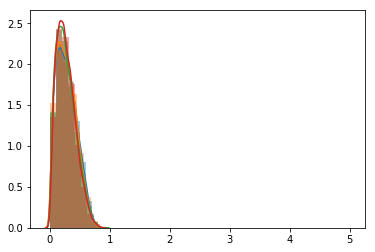

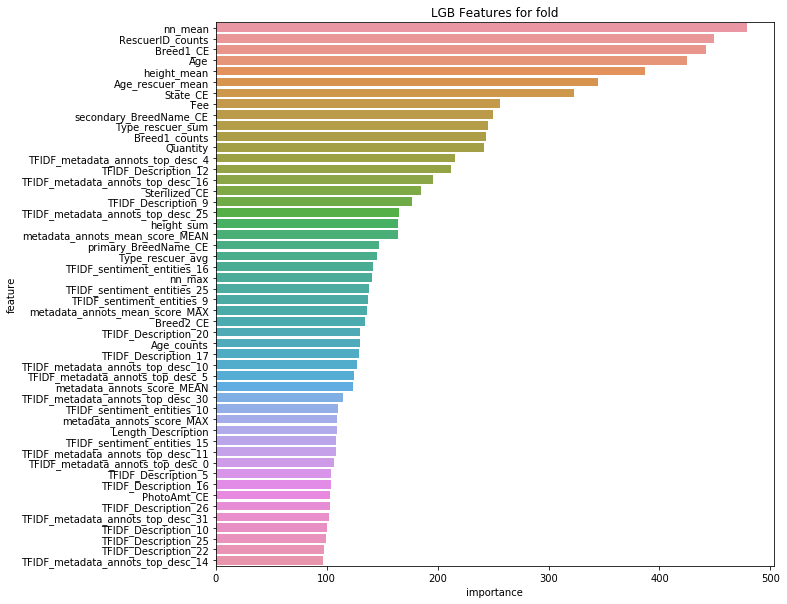

[0]	train-rmse:2.29783	valid-rmse:2.29791
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.0063	valid-rmse:1.09401
[200]	train-rmse:0.88735	valid-rmse:1.05425
[300]	train-rmse:0.829181	valid-rmse:1.05294
[400]	train-rmse:0.784604	valid-rmse:1.05299
Stopping. Best iteration:
[370]	train-rmse:0.798064	valid-rmse:1.05239

Train on 7496 samples, validate on 7497 samples
Epoch 1/15
 - 2s - loss: 1.5123 - acc: 0.2062 - val_loss: 1.3443 - val_acc: 0.2514
Epoch 2/15
 - 0s - loss: 1.2305 - acc: 0.2447 - val_loss: 1.2398 - val_acc: 0.2564
Epoch 3/15
 - 0s - loss: 1.1617 - acc: 0.2583 - val_loss: 1.2658 - val_acc: 0.2568
Epoch 4/15
 - 0s - loss: 1.1100 - acc: 0.2696 - val_loss: 1.1486 - val_acc: 0.2694
Epoch 5/15
 - 0s - loss: 1.0713 - acc: 0.2785 - val_loss: 1.1979 - val_acc: 0.2645
Epoch 6/15
 - 0s - loss: 1.0389 - acc: 0.2876 - val_loss: 1.1123 - val_acc: 0.2792
Epoch 7/15
 - 0s 

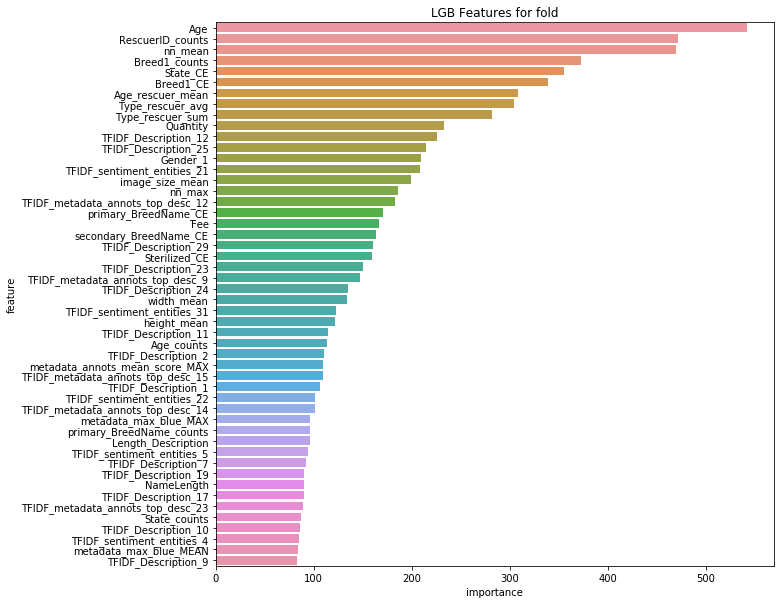

[0]	train-rmse:2.29818	valid-rmse:2.29909
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.99985	valid-rmse:1.10687
[200]	train-rmse:0.876004	valid-rmse:1.05804
[300]	train-rmse:0.815074	valid-rmse:1.05669
[400]	train-rmse:0.76578	valid-rmse:1.05814
Stopping. Best iteration:
[305]	train-rmse:0.81234	valid-rmse:1.05646

Train on 7497 samples, validate on 7496 samples
Epoch 1/15
 - 2s - loss: 1.8545 - acc: 0.1663 - val_loss: 1.5899 - val_acc: 0.2090
Epoch 2/15
 - 0s - loss: 1.2755 - acc: 0.2436 - val_loss: 1.5040 - val_acc: 0.2174
Epoch 3/15
 - 0s - loss: 1.2037 - acc: 0.2534 - val_loss: 1.4056 - val_acc: 0.2216
Epoch 4/15
 - 0s - loss: 1.1285 - acc: 0.2704 - val_loss: 1.1472 - val_acc: 0.2601
Epoch 5/15
 - 0s - loss: 1.0891 - acc: 0.2673 - val_loss: 1.1714 - val_acc: 0.2604
Epoch 6/15
 - 0s - loss: 1.0602 - acc: 0.2780 - val_loss: 1.1489 - val_acc: 0.2648
Epoch 7/15
 - 0s 

In [149]:
res = train_and_test_model(X_trn, y_trn, X_test, num_folds=2, model_type='boost', use_group_kfold=True)


In [ ]:
# y_bin = np.zeros(y_trn.shape)
# y_bin[y_trn == 4] = 1

In [ ]:
# bin_res = train_and_test_model(X_trn, y_bin, X_test, bin_params, num_folds=10, use_group_kfold=True)

In [150]:
coef_1 = 0
coef_2 = 0
coef_3 = 1

vp = coef_1*res['val_preds'] + coef_2*res['xgb_val_preds'] + coef_3*res['nn_val_preds']
tp = coef_1*res['averaged_prediction'] + coef_2*res['xgb_averaged_prediction'] + coef_3*res['nn_averaged_prediction']

In [151]:
optR = OptimizedRounder()
optR.fit(vp, y_trn.values)
coefficients = optR.coefficients()

valid_pred = optR.predict(vp, coefficients)
qwk = quadratic_weighted_kappa(y_trn.values, valid_pred)
print("QWK = ", qwk)
print(coefficients)
coefficients_2 = (np.array(coefficients) + np.array([0.5, 1.5, 2.5, 3.5]))/2
valid_pred = optR.predict(vp, coefficients_2)
qwk = quadratic_weighted_kappa(y_trn.values, valid_pred)
print("QWK = ", qwk)

QWK =  0.2734165155018664
[ 0.5516243   1.55970031  1.89793009  3.55814354]
QWK =  0.25104294651073045


In [ ]:
# print(coefficients)

In [ ]:
def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={'range': [0, 5]})

In [ ]:
plot_pred(y_trn)

In [ ]:
plot_pred(res['val_preds'])

In [ ]:
plot_pred(res['averaged_prediction'])

In [ ]:
coefficients

In [ ]:
coefficients_ = coefficients.copy()

train_predictions = optR.predict(res['val_preds'], coefficients_).astype(np.int8)
print('train pred distribution: {}'.format(Counter(train_predictions)))
test_predictions = optR.predict(res['averaged_prediction'], coefficients_).astype(np.int8)
print('test pred distribution: {}'.format(Counter(test_predictions)))

In [ ]:
Counter(train_predictions)

In [ ]:
Counter(test_predictions)

In [ ]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})
submission.to_csv('submission.csv', index=False)
submission.head()